In [1]:
# Text Classification / tc-nltk-lstm-rnn-6.ipynb
# Gourav Siddhad
# 24-Mar-2019

In [2]:
print('Importing Libraries', end='')

import pandas as pd
import numpy as np
from numpy.random import seed
import re
import os
import pandas as pd
import time

import matplotlib.pyplot as plt

import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import reuters, stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

from scipy import interp
from itertools import cycle

print(' - Done')

Importing Libraries

Using TensorFlow backend.


 - Done


In [3]:
documents = reuters.fileids()
print('Total Documents -', len(documents))

print('Extracting (Id, Docs and Labels)', end='')
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]
all_docs = train_docs
all_docs += test_docs

train_labels = [reuters.categories(doc_id) for doc_id in train_docs_id]
test_labels  = [reuters.categories(doc_id) for doc_id in test_docs_id]
all_labels = train_labels
all_labels += test_labels
print(' - Done')

del train_docs
del test_docs
del train_labels
del test_labels

print('Documents - ', len(all_docs))
print('Labels  - ', len(all_labels))

# List of categories
categories = reuters.categories()
print('Categories - ', len(categories))

Total Documents - 10788
Extracting (Id, Docs and Labels) - Done
Documents -  10788
Labels  -  10788
Categories -  90


In [4]:
print('Caching Stop Words', end='')
cachedStopWords = stopwords.words("english")
print(' - Done')

Caching Stop Words - Done


In [5]:
print('Sorting Train:Test Docs', end='')
X_train, X_test, y_train, y_test = train_test_split(all_docs, all_labels, test_size=0.2, random_state=42)
print(' - Done')

maxwords = 5000

print('Tokenizing', end='')
tk = Tokenizer(num_words=maxwords)
tk.fit_on_texts(X_train)
tk.fit_on_texts(X_test)
index_list_train = tk.texts_to_sequences(X_train)
index_list_test = tk.texts_to_sequences(X_test)
print(' - Done')

Sorting Train:Test Docs - Done
Tokenizing - Done


In [6]:
# max of index_list_train
# max of index_list_test

maxlen = 200

for i in index_list_train:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

for i in index_list_test:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

2237
2237


In [7]:
maxlen = 1600

print('Padding Sequences', end='')
x_train = sequence.pad_sequences(index_list_train, maxlen=maxlen)
x_test = sequence.pad_sequences(index_list_test, maxlen=maxlen)
print(' - Done')

print('Binarizing MultiLabels', end='')
lb = MultiLabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print(' - Done')

Padding Sequences - Done
Binarizing MultiLabels - Done


In [8]:
del all_docs
del all_labels

def RNN():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(maxwords, 512, input_length=maxlen)(inputs)
    layer = LSTM(256)(layer)
    layer = Dense(128, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(rate = 0.5)(layer) # rate = 1-keep_prob, keep_prob=0.5
    layer = Dense(len(categories), name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [9]:
model = RNN()
model.summary()
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1600)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1600, 512)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 90)                11610     
__________

In [10]:
history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.3, shuffle=True)

Train on 6041 samples, validate on 2589 samples
Epoch 1/100
6041/6041 [==============================] - 184s 30ms/step - loss: 0.0134 - acc: 0.2943 - val_loss: 0.0135 - val_acc: 0.3766
Epoch 2/100
6041/6041 [==============================] - 181s 30ms/step - loss: 0.0122 - acc: 0.3443 - val_loss: 0.0114 - val_acc: 0.3766
Epoch 3/100
6041/6041 [==============================] - 193s 32ms/step - loss: 0.0107 - acc: 0.3960 - val_loss: 0.0097 - val_acc: 0.4708
Epoch 4/100
6041/6041 [==============================] - 194s 32ms/step - loss: 0.0114 - acc: 0.3827 - val_loss: 0.0102 - val_acc: 0.4013
Epoch 5/100
6041/6041 [==============================] - 195s 32ms/step - loss: 0.0108 - acc: 0.3837 - val_loss: 0.0098 - val_acc: 0.3422
Epoch 6/100
6041/6041 [==============================] - 197s 33ms/step - loss: 0.0095 - acc: 0.4991 - val_loss: 0.0094 - val_acc: 0.5481
Epoch 7/100
6041/6041 [==============================] - 190s 31ms/step - loss: 0.0091 - acc: 0.5335 - val_loss: 0.0090 - va

6041/6041 [==============================] - 189s 31ms/step - loss: 0.0052 - acc: 0.7346 - val_loss: 0.0064 - val_acc: 0.6883
Epoch 60/100
6041/6041 [==============================] - 191s 32ms/step - loss: 0.0049 - acc: 0.7469 - val_loss: 0.0062 - val_acc: 0.6960
Epoch 61/100
6041/6041 [==============================] - 189s 31ms/step - loss: 0.0046 - acc: 0.7633 - val_loss: 0.0061 - val_acc: 0.7072
Epoch 62/100
6041/6041 [==============================] - 187s 31ms/step - loss: 0.0046 - acc: 0.7651 - val_loss: 0.0062 - val_acc: 0.7010
Epoch 63/100
6041/6041 [==============================] - 189s 31ms/step - loss: 0.0047 - acc: 0.7550 - val_loss: 0.0064 - val_acc: 0.6856
Epoch 64/100
6041/6041 [==============================] - 187s 31ms/step - loss: 0.0045 - acc: 0.7636 - val_loss: 0.0061 - val_acc: 0.7030
Epoch 65/100
6041/6041 [==============================] - 186s 31ms/step - loss: 0.0043 - acc: 0.7740 - val_loss: 0.0059 - val_acc: 0.7061
Epoch 66/100
6041/6041 [================

In [11]:
# Save Complete Model
model.save('tc-nltk-lstm-rnn-6.h5')

# Load a Saved Model
# model = load_model('tc-nltk-lstm-rnn.h5')

# Delete a model
# del model

# Save Model Configuration to JSON
model_json = model.to_json()
with open('tc-nltk-lstm-rnn-6.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('tc-nltk-lstm-rnn-6-weights.h5')

# Load Model Configuration from JSON
# json_file = open('tc-nltk-lstm-rnn.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights('tc-nltk-lstm-rnn-weights.h5')
# loaded_model.save('tc-nltk-lstm-rnn-weights.hdf5')
# loaded_model=load_model('tc-nltk-lstm-rnn-weights.hdf5')

In [12]:
accr = model.evaluate(x_test, y_test, batch_size=256)
print()
print('Loss: {:0.3f}\tAccuracy: {:0.3f}'.format(accr[0], accr[1]))

2158/2158 [==============================] - 23s 10ms/step

Loss: 0.006	Accuracy: 0.745


In [13]:
# plot_model(model, to_file='tc-nltk-lstm-4-model.png')

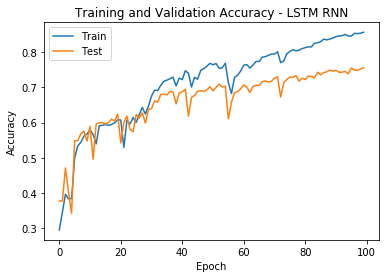

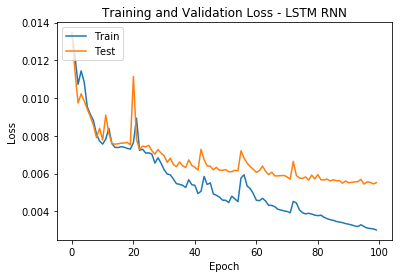

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy - LSTM RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-6-acc.png', dpi=300, pad_inches=0.1)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss - LSTM RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-6-loss.png', dpi=300, pad_inches=0.1)
plt.show()